In [1]:
# nltk.download('stopwords')

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [6]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [7]:
data = df[0].dropna().tolist()

In [8]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_93411/1419459543.py:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_93411/1419459543.py:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [10]:
print(data_words[3][:30])

['associated', 'press', 'beijing', 'heavy', 'flooding', 'has', 'displaced', 'thousands', 'of', 'people', 'around', 'china', 'as', 'the', 'capital', 'had', 'relative', 'respite', 'from', 'sweltering', 'heat', 'beijing', 'reported', 'straight', 'days', 'when', 'the', 'temperature', 'exceeded', 'the']


In [11]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops)

In [13]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## Bigrams and Trigrams

In [14]:
bigram = Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [15]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words]

In [16]:
# random example truncated  
data_with_phrases[3][:30]

['associated_press',
 'beijing',
 'heavy',
 'flooding',
 'has',
 'displaced_thousands',
 'of',
 'people',
 'around',
 'china',
 'as',
 'the',
 'capital',
 'had',
 'relative_respite',
 'from',
 'sweltering_heat',
 'beijing',
 'reported',
 'straight',
 'days',
 'when',
 'the',
 'temperature_exceeded',
 'the',
 'national',
 'climate',
 'center',
 'said',
 'monday']

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_with_phrases)
id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12


# Create Corpus
texts = data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [18]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
# Build LDA model

# increased chunk size to speed up development
# LdaMulticoreModel had slower training time, would have otherwise used it 

lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=20, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

2023-11-05 10:07:49,497 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2023-11-05 10:07:49,498 : INFO : using serial LDA version on this node
2023-11-05 10:07:49,510 : INFO : running online (multi-pass) LDA training, 20 topics, 10 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 10000 documents, iterating 50x with a convergence threshold of 0.001000
2023-11-05 10:07:49,511 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-11-05 10:07:50,435 : INFO : optimized alpha [0.07342489, 0.06974665, 0.06536586, 0.07216138, 0.07180391, 0.06942558, 0.07528917, 0.065201975, 0.06949973, 0.0695292, 0.065026745, 0.06691861, 0.07388379, 0.06751655, 0.0743801, 0.06965591, 0.0732669, 0.072142474, 0.07200443, 0.07058001]
2023-11-05 10:07:50,445 : INFO : merging changes from 2000 documents into a model of 10000

In [20]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 12495
Number of documents: 10000


In [21]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

2023-11-05 10:08:47,050 : INFO : topic #0 (0.033): 0.034*"die" + 0.022*"der" + 0.018*"und" + 0.017*"tesla" + 0.010*"market" + 0.010*"von" + 0.009*"das" + 0.009*"sales" + 0.008*"zu" + 0.007*"ist"
2023-11-05 10:08:47,052 : INFO : topic #1 (0.015): 0.043*"event" + 0.041*"your" + 0.040*"day" + 0.032*"mile" + 0.031*"walk" + 0.031*"two" + 0.031*"in_los_angeles" + 0.030*"their" + 0.030*"well" + 0.025*"dogs"
2023-11-05 10:08:47,053 : INFO : topic #2 (0.011): 0.159*"republic" + 0.040*"people" + 0.012*"state" + 0.011*"ecuador" + 0.010*"south" + 0.009*"democratic" + 0.009*"new" + 0.008*"socialist_republic" + 0.007*"kingdom" + 0.006*"islamic_republic"
2023-11-05 10:08:47,054 : INFO : topic #3 (0.054): 0.011*"xi" + 0.009*"economic" + 0.007*"his" + 0.007*"state" + 0.007*"world" + 0.007*"new" + 0.006*"political" + 0.006*"party" + 0.006*"power" + 0.005*"country"
2023-11-05 10:08:47,055 : INFO : topic #4 (0.066): 0.014*"year" + 0.010*"economy" + 0.010*"growth" + 0.008*"you" + 0.007*"market" + 0.007*"up

In [22]:
# Print the Keyword
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

2023-11-05 10:08:47,080 : INFO : topic #0 (0.033): 0.034*"die" + 0.022*"der" + 0.018*"und" + 0.017*"tesla" + 0.010*"market" + 0.010*"von" + 0.009*"das" + 0.009*"sales" + 0.008*"zu" + 0.007*"ist"
2023-11-05 10:08:47,081 : INFO : topic #1 (0.015): 0.043*"event" + 0.041*"your" + 0.040*"day" + 0.032*"mile" + 0.031*"walk" + 0.031*"two" + 0.031*"in_los_angeles" + 0.030*"their" + 0.030*"well" + 0.025*"dogs"
2023-11-05 10:08:47,081 : INFO : topic #2 (0.011): 0.159*"republic" + 0.040*"people" + 0.012*"state" + 0.011*"ecuador" + 0.010*"south" + 0.009*"democratic" + 0.009*"new" + 0.008*"socialist_republic" + 0.007*"kingdom" + 0.006*"islamic_republic"
2023-11-05 10:08:47,082 : INFO : topic #3 (0.054): 0.011*"xi" + 0.009*"economic" + 0.007*"his" + 0.007*"state" + 0.007*"world" + 0.007*"new" + 0.006*"political" + 0.006*"party" + 0.006*"power" + 0.005*"country"
2023-11-05 10:08:47,082 : INFO : topic #4 (0.066): 0.014*"year" + 0.010*"economy" + 0.010*"growth" + 0.008*"you" + 0.007*"market" + 0.007*"up

[(0, '0.034*"die" + 0.022*"der" + 0.018*"und" + 0.017*"tesla" + 0.010*"market" + 0.010*"von" + 0.009*"das" + 0.009*"sales" + 0.008*"zu" + 0.007*"ist"'), (1, '0.043*"event" + 0.041*"your" + 0.040*"day" + 0.032*"mile" + 0.031*"walk" + 0.031*"two" + 0.031*"in_los_angeles" + 0.030*"their" + 0.030*"well" + 0.025*"dogs"'), (2, '0.159*"republic" + 0.040*"people" + 0.012*"state" + 0.011*"ecuador" + 0.010*"south" + 0.009*"democratic" + 0.009*"new" + 0.008*"socialist_republic" + 0.007*"kingdom" + 0.006*"islamic_republic"'), (3, '0.011*"xi" + 0.009*"economic" + 0.007*"his" + 0.007*"state" + 0.007*"world" + 0.007*"new" + 0.006*"political" + 0.006*"party" + 0.006*"power" + 0.005*"country"'), (4, '0.014*"year" + 0.010*"economy" + 0.010*"growth" + 0.008*"you" + 0.007*"market" + 0.007*"up" + 0.007*"economic" + 0.006*"our" + 0.006*"data" + 0.006*"last"'), (5, '0.131*"de" + 0.053*"la" + 0.048*"en" + 0.046*"el" + 0.045*"que" + 0.016*"los" + 0.015*"un" + 0.014*"para" + 0.013*"una" + 0.013*"se"'), (6, '0.0

In [23]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [24]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [25]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.100799  0.116173       1        1  12.047498
15     0.094890  0.002416       2        1  11.330828
4      0.078504 -0.109582       3        1   9.127904
8      0.070385 -0.029766       4        1   7.102964
10     0.078998 -0.011564       5        1   7.079698
19     0.108526  0.098132       6        1   6.848159
14     0.084938 -0.006175       7        1   6.413990
16     0.105311  0.071484       8        1   5.636733
12     0.095114  0.126586       9        1   5.602637
3      0.100163  0.063513      10        1   5.449490
5     -0.424901  0.078281      11        1   5.212337
13     0.087940 -0.042405      12        1   4.500478
7      0.059054 -0.034678      13        1   3.751649
11     0.076333  0.149996      14        1   3.523919
0     -0.091452 -0.220034      15        1   2.257678
6      0.017706 -0.068770      16        1   1.513659
9     -0.030972 -0.094675      17        1   1.414364
17    -0.099915 -0.176386      18        1   0.609284
2     -0.341220  0.195125      19        1   0.328613
1     -0.170201 -0.107671      20        1   0.248119, topic_info=         Term          Freq         Total Category  logprob  loglift
688        de  21534.000000  21534.000000  Default  30.0000  30.0000
1247   taiwan  11616.000000  11616.000000  Default  29.0000  29.0000
748        la   8590.000000   8590.000000  Default  28.0000  28.0000
707        en   7859.000000   7859.000000  Default  27.0000  27.0000
704        el   7345.000000   7345.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
970   address     61.296567    799.632623  Topic20  -4.8296   3.4306
1332     news     60.049234   3576.521171  Topic20  -4.8501   1.9120
8       after     61.597126   9629.385971  Topic20  -4.8247   0.9471
2136  morning     53.742885    684.996327  Topic20  -4.9611   3.4538
4465  stories     50.959034    455.964618  Topic20  -5.0143   3.8076

[1522 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4097       6  0.988655  abortion
1          1  0.076840     about
1          2  0.230779     about
1          3  0.100955     about
1          4  0.079520     about
...      ...       ...       ...
10292     12  0.974139      zinc
10565      4  0.995123       zoo
6817      12  0.973642   zookeys
10566      4  0.974512      zoos
5049      15  0.998203        zu

[5768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 16, 5, 9, 11, 20, 15, 17, 13, 4, 6, 14, 8, 12, 1, 7, 10, 18, 3, 2])

In [26]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

2023-11-05 10:08:58,458 : INFO : -7.552 per-word bound, 187.7 perplexity estimate based on a held-out corpus of 10000 documents with 3091994 words



Perplexity:  -7.552040248352219


In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_with_phrases, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2023-11-05 10:12:25,550 : INFO : using ParallelWordOccurrenceAccumulator(processes=9, batch_size=64) to estimate probabilities from sliding windows
2023-11-05 10:12:30,401 : INFO : 1 batches submitted to accumulate stats from 64 documents (26281 virtual)
2023-11-05 10:12:30,405 : INFO : 2 batches submitted to accumulate stats from 128 documents (48380 virtual)
2023-11-05 10:12:30,409 : INFO : 3 batches submitted to accumulate stats from 192 documents (73806 virtual)
2023-11-05 10:12:30,414 : INFO : 4 batches submitted to accumulate stats from 256 documents (102157 virtual)
2023-11-05 10:12:30,419 : INFO : 5 batches submitted to accumulate stats from 320 documents (127090 virtual)
2023-11-05 10:12:30,425 : INFO : 6 batches submitted to accumulate stats from 384 documents (160307 virtual)
2023-11-05 10:12:30,428 : INFO : 7 batches submitted to accumulate stats from 448 documents (179648 virtual)
2023-11-05 10:12:30,436 : INFO : 8 batches submitted to accumulate stats from 512 documents (


Coherence Score:  0.4812182571876457


## Find optimzed number of topics

In [29]:
# find optimal amount of topics
# topics = list(range(12,31))
# score = []

# for i in topics:
#     lda_model = LdaModel(corpus=corpus,
#                     id2word=id2word,
#                     num_topics=i, 
#                     random_state=100,
#                     update_every=1,
#                     chunksize=100,
#                     passes=10,
#                     alpha='auto',
#                     eta='auto',
#                     per_word_topics=True)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_with_phrases, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     score.append(coherence_model_lda.get_coherence())

In [30]:
# output from the commented cell above
score, topics = ([0.5878793093478382,
  0.5435314696614544,
  0.5565374497160931,
  0.5565600484859501,
  0.5719076270797666,
  0.52992289016823,
  0.5427521080880734,
  0.5449226968106219,
  0.5655869210194248,
  0.5691342096011647,
  0.569088424991265,
  0.5693970351038482,
  0.5635094171957752,
  0.5652035672585817,
  0.5655983152786692,
  0.5650318285288093,
  0.5574841505280901,
  0.5601045758986688,
  0.5582273063504627],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [31]:
score, topics

([0.5878793093478382,
  0.5435314696614544,
  0.5565374497160931,
  0.5565600484859501,
  0.5719076270797666,
  0.52992289016823,
  0.5427521080880734,
  0.5449226968106219,
  0.5655869210194248,
  0.5691342096011647,
  0.569088424991265,
  0.5693970351038482,
  0.5635094171957752,
  0.5652035672585817,
  0.5655983152786692,
  0.5650318285288093,
  0.5574841505280901,
  0.5601045758986688,
  0.5582273063504627],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

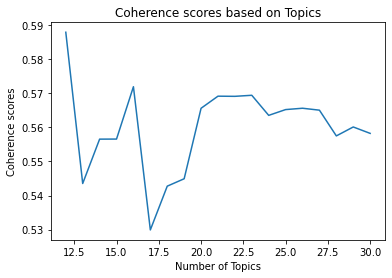

In [32]:
import matplotlib.pyplot as plt

# Initialize the matplotlib figure
# plt.figure(figsize=(10, 6))

# Create a seaborn lineplot
plt.plot(topics, score)

# You could also create a scatter plot by using sns.scatterplot instead of sns.lineplot
# sns.scatterplot(x=x_array, y=y_array)

# Customize your plot with labels, titles, etc.
plt.title('Coherence scores based on Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence scores')

# Show the plot
# plt.show()
plt.show()